# DATA PROCESSING

In [58]:
import pandas as pd

def parse_extended_time(tstr):
    """
    Konwertuje czas w formacie 'HH:MM:SS' (nawet gdy HH >= 24)
    na obiekt Timestamp z uwzględnieniem przesunięcia o całe doby.
    """
    h, m, s = tstr.split(':')
    h, m, s = int(h), int(m), int(s)

    day_offset = h // 24
    hour_in_day = h % 24

    base_date = pd.Timestamp(year=2025, month=1, day=1)
    date_time = base_date + pd.Timedelta(days=day_offset, hours=hour_in_day, minutes=m, seconds=s)

    return date_time

# Wczytanie pliku CSV z jawnym określeniem typów
df = pd.read_csv(
    "connection_graph.csv",
    dtype={
        "id": "int64",
        "company": "string",
        "line": "string", 
        "start_stop": "string",
        "end_stop": "string",
        "start_stop_lat": "float64",
        "start_stop_lon": "float64",
        "end_stop_lat": "float64",
        "end_stop_lon": "float64"
    },
    low_memory=False  # To pomaga przy dużych plikach
)

# Konwersja czasów
df["departure_time"] = df["departure_time"].apply(parse_extended_time)
df["arrival_time"] = df["arrival_time"].apply(parse_extended_time)

# Sprawdzenie typów
print(df.dtypes)
print(df.head())

Unnamed: 0                 int64
company           string[python]
line              string[python]
departure_time    datetime64[ns]
arrival_time      datetime64[ns]
start_stop        string[python]
end_stop          string[python]
start_stop_lat           float64
start_stop_lon           float64
end_stop_lat             float64
end_stop_lon             float64
dtype: object
   Unnamed: 0       company line      departure_time        arrival_time  \
0           0  MPK Autobusy    A 2025-01-01 20:52:00 2025-01-01 20:53:00   
1           1  MPK Autobusy    A 2025-01-01 20:53:00 2025-01-01 20:54:00   
2           2  MPK Autobusy    A 2025-01-01 20:54:00 2025-01-01 20:55:00   
3           3  MPK Autobusy    A 2025-01-01 20:55:00 2025-01-01 20:57:00   
4           4  MPK Autobusy    A 2025-01-01 20:57:00 2025-01-01 20:59:00   

             start_stop              end_stop  start_stop_lat  start_stop_lon  \
0   Zajezdnia Obornicka              Paprotna       51.148737       17.021069   
1   

### Creating class Connection and Stop

In [70]:
import re
from datetime import datetime

class Connection:
    def __init__(self, line, start, end, departure_time, arrival_time):
        self.line = line
        self.start: Stop = start 
        self.end: Stop = end  
        self.departure_time = departure_time
        self.arrival_time = arrival_time
        self.travel_time = (arrival_time - departure_time).total_seconds()
        
    def __repr__(self):
        return (f"Connection({self.line}, {self.start.name} -> {self.end.name}, "
                f"{self.departure_time.strftime('%H:%M:%S')} - {self.arrival_time.strftime('%H:%M:%S')})")


class Stop:
    def __init__(self, name, lat, lon):
        self.name = name
        self.lat = lat
        self.lon = lon
        self.connections: Connection = []

    def add_connection(self, connection):
        self.connections.append(connection)

    def __repr__(self):
        return f"Stop({self.name}, {self.lat}, {self.lon})"

    # Function to normalize stop names (e.g. remove dots, spaces)
    @staticmethod
    def normalize_name(name):
        # Removing dots and trimming spaces
        return re.sub(r'\s|\.', '', name).lower()

### Creating graph where each node is a Stop and each edge is a Connection

In [75]:
stop_graph = {}
for _, row in df.iterrows():
    start_name = row["start_stop"]
    end_name = row["end_stop"]
    
    if start_name not in stop_graph:
        stop_graph[start_name] = Stop(start_name, row["start_stop_lat"], row["start_stop_lon"])
    if end_name not in stop_graph:
        stop_graph[end_name] = Stop(end_name, row["end_stop_lat"], row["end_stop_lon"])
    
    connection = Connection(
        line=row["line"],
        start=stop_graph[start_name],
        end=stop_graph[end_name],
        departure_time=row["departure_time"],
        arrival_time=row["arrival_time"]
    )
    
    stop_graph[start_name].add_connection(connection)

# Previewing data
test_stop = next(iter(stop_graph.values()))
print(test_stop)
print(test_stop.connections)


Stop(Zajezdnia Obornicka, 51.14873744, 17.02106859)
[Connection(A, Zajezdnia Obornicka -> Paprotna, 20:52:00 - 20:53:00), Connection(A, Zajezdnia Obornicka -> Paprotna, 21:46:00 - 21:47:00), Connection(A, Zajezdnia Obornicka -> Paprotna, 20:22:00 - 20:23:00), Connection(A, Zajezdnia Obornicka -> Paprotna, 05:36:00 - 05:37:00), Connection(A, Zajezdnia Obornicka -> Paprotna, 05:26:00 - 05:27:00), Connection(A, Zajezdnia Obornicka -> Paprotna, 04:09:00 - 04:10:00), Connection(A, Zajezdnia Obornicka -> Paprotna, 04:39:00 - 04:40:00), Connection(A, Zajezdnia Obornicka -> Paprotna, 05:09:00 - 05:10:00), Connection(A, Zajezdnia Obornicka -> Paprotna, 20:52:00 - 20:53:00), Connection(A, Zajezdnia Obornicka -> Paprotna, 21:46:00 - 21:47:00), Connection(A, Zajezdnia Obornicka -> Paprotna, 20:22:00 - 20:23:00), Connection(A, Zajezdnia Obornicka -> Paprotna, 05:36:00 - 05:37:00), Connection(A, Zajezdnia Obornicka -> Paprotna, 05:26:00 - 05:27:00), Connection(A, Zajezdnia Obornicka -> Paprotna, 04:

In [76]:
import heapq
import time
from datetime import datetime, timedelta

def find_earliest_connection(connections, current_time, previous_line=None, boarding_time=1):

    transfer_delta = timedelta(minutes=boarding_time)
    earliest = None
    for conn in connections:
        # Jeśli nie jeździmy tą samą linią, trzeba doliczyć czas transferu.
        required_departure = current_time if (previous_line is None or conn.line == previous_line) else current_time + transfer_delta
        if conn.departure_time >= required_departure:
            if earliest is None or conn.departure_time < earliest.departure_time:
                earliest = conn
    return earliest


class DijkstraRouter:
    def __init__(self, stop_graph):
        self.stop_graph = stop_graph

    def _validate_stops(self, start_stop, end_stop):
        if start_stop not in self.stop_graph or end_stop not in self.stop_graph:
            print("ERROR: Przystanek startowy lub końcowy nie istnieje w grafie.")
            return False
        return True

    def _initialize_search_structures(self, start_stop, start_time):
        base_date = datetime(2025, 1, 1)
        start_datetime = base_date.replace(hour=start_time.hour, minute=start_time.minute, second=start_time.second)
        
        travel_times = {name: float('inf') for name in self.stop_graph}
        previous = {name: None for name in self.stop_graph}
        arrival_times = {name: None for name in self.stop_graph}
        previous_lines = {name: None for name in self.stop_graph}
        
        travel_times[start_stop] = 0
        arrival_times[start_stop] = start_datetime
        
        return (travel_times, previous, arrival_times, previous_lines, start_datetime)

    def _group_connections_by_destination(self, current_stop):
        grouped_connections = {}
        for conn in current_stop.connections:
            destination = conn.end.name
            if destination not in grouped_connections:
                grouped_connections[destination] = []
            grouped_connections[destination].append(conn)
        return grouped_connections

    def _reconstruct_route(self, previous, end_stop):
        route = []
        current = end_stop
        while current and previous[current]:
            prev_stop, conn = previous[current]
            route.append(conn)
            current = prev_stop
        route.reverse()
        return route

    def find_route(self, start_stop, end_stop, start_time, boarding_time=1):

        if not self._validate_stops(start_stop, end_stop):
            return None

        start_measure = time.time()

        # Initialize search structures
        travel_times, previous, arrival_times, previous_lines, current_time = self._initialize_search_structures(start_stop, start_time)
        
        # Priority queue for Dijkstra's algorithm
        priority_queue = [(0, start_stop)]
        
        while priority_queue:
            current_travel_time, current_stop_name = heapq.heappop(priority_queue)
            
            # Destination reached
            if current_stop_name == end_stop:
                break
            
            # Skip if we have better time for this stop
            if current_travel_time > travel_times[current_stop_name]:
                continue
            
            current_stop = self.stop_graph[current_stop_name]
            current_arrival_time = arrival_times[current_stop_name]
            current_line = previous_lines[current_stop_name]
            
            # Group connections by destination
            grouped_connections = self._group_connections_by_destination(current_stop)
            
            for next_stop_name, conns in grouped_connections.items():
                # Find earliest connection respecting transfer rules
                earliest_conn = find_earliest_connection(
                    conns, current_arrival_time, 
                    previous_line=current_line, 
                    boarding_time=boarding_time
                )
                
                if earliest_conn is None:
                    continue
                
                # Calculate travel time
                travel_time = (earliest_conn.arrival_time - current_arrival_time).total_seconds() / 60
                
                # Update if we found a faster route
                if current_travel_time + travel_time < travel_times[next_stop_name]:
                    travel_times[next_stop_name] = current_travel_time + travel_time
                    previous[next_stop_name] = (current_stop_name, earliest_conn)
                    arrival_times[next_stop_name] = earliest_conn.arrival_time
                    previous_lines[next_stop_name] = earliest_conn.line
                    
                    heapq.heappush(priority_queue, (travel_times[next_stop_name], next_stop_name))
        
        end_measure = time.time()
          
        if travel_times[end_stop] == float('inf'):
            print("DEBUG: Brak dostępnej trasy!")
            return None
        
        # Reconstruct route
        route = self._reconstruct_route(previous, end_stop)
        
        # Calculate total travel time
        hours = travel_times[end_stop] // 60
        minutes = travel_times[end_stop] % 60
        total_cost = f"{int(hours)}h {int(minutes)}min"
        
        return {
            'route': route,
            'total_cost': total_cost,
            'calculation_time': end_measure - start_measure,
            'transfers': None
        }



# --- Użycie routera ---
router = DijkstraRouter(stop_graph)

start_stop = "Wilczyce - Sosnowa"
end_stop = "Kołobrzeska"
start_time_str = "07:00:00"
start_time = datetime.strptime(start_time_str, "%H:%M:%S")

result = router.find_route(start_stop, end_stop, start_time)

if result:
    print("\nHarmonogram przejazdu:")
    for connection in result['route']:
        print(f"Linia: {connection.line}, "
              f"Z: {connection.start.name} o {connection.departure_time.strftime('%H:%M:%S')}, "
              f"Do: {connection.end.name} o {connection.arrival_time.strftime('%H:%M:%S')}")
    print(f"\nKoszt trasy (min): {result['total_cost']}")
    print(f"Czas obliczeń: {result['calculation_time']:.4f} sekund")
else:
    print("Nie znaleziono trasy.")



Harmonogram przejazdu:
Linia: 911, Z: Wilczyce - Sosnowa o 07:10:00, Do: Wilczyce - Dębowa o 07:11:00
Linia: 911, Z: Wilczyce - Dębowa o 07:11:00, Do: Wilczyce - Dworska o 07:12:00
Linia: 911, Z: Wilczyce - Dworska o 07:12:00, Do: Wilczyce - Borowa o 07:13:00
Linia: 911, Z: Wilczyce - Borowa o 07:13:00, Do: Wilczyce - Wrocławska (na wys. nr 1F) o 07:14:00
Linia: 911, Z: Wilczyce - Wrocławska (na wys. nr 1F) o 07:14:00, Do: Wilczyce o 07:14:00
Linia: 911, Z: Wilczyce o 07:14:00, Do: Mroźna o 07:15:00
Linia: 911, Z: Mroźna o 07:15:00, Do: Kurlandzka o 07:15:00
Linia: 911, Z: Kurlandzka o 07:15:00, Do: Zgorzelisko o 07:16:00
Linia: 911, Z: Zgorzelisko o 07:16:00, Do: Palacha o 07:17:00
Linia: 911, Z: Palacha o 07:17:00, Do: Szewczenki o 07:18:00
Linia: 911, Z: Szewczenki o 07:18:00, Do: Gorlicka o 07:19:00
Linia: 911, Z: Gorlicka o 07:19:00, Do: MULICKA o 07:20:00
Linia: 911, Z: MULICKA o 07:20:00, Do: Psie Pole (Rondo Lotników Polskich) o 07:21:00
Linia: 911, Z: Psie Pole (Rondo Lotnikó

In [77]:
import heapq
import time
import math
from datetime import datetime, timedelta

class AStarRouter:
    def __init__(self, stop_graph, heuristic):
        self.stop_graph = stop_graph  # Dictionary: key = stop name (str), value = Stop object
        self.heuristic = heuristic    # Heuristic function taking two Stop objects

    def _validate_stops(self, start_stop, end_stop):
        if start_stop not in self.stop_graph or end_stop not in self.stop_graph:
            print("ERROR: Start or end stop does not exist in the graph.")
            return False
        return True

    def _initialize_search_structures(self, start_stop, start_time):
        base_date = datetime(2025, 1, 1)
        start_datetime = base_date.replace(hour=start_time.hour, minute=start_time.minute, second=start_time.second)

        travel_times = {name: float('inf') for name in self.stop_graph}
        previous = {name: None for name in self.stop_graph}
        arrival_times = {name: None for name in self.stop_graph}
        previous_lines = {name: None for name in self.stop_graph}

        travel_times[start_stop] = 0
        arrival_times[start_stop] = start_datetime

        return travel_times, previous, arrival_times, previous_lines, start_datetime

    def _group_connections_by_destination(self, current_stop):
        grouped_connections = {}
        for conn in current_stop.connections:
            destination = conn.end.name
            if destination not in grouped_connections:
                grouped_connections[destination] = []
            grouped_connections[destination].append(conn)
        return grouped_connections

    def _reconstruct_route(self, previous, end_stop):
        route = []
        current = end_stop  # end_stop as a string (stop name)
        while current and previous[current]:
            prev_stop, conn = previous[current]
            route.append(conn)
            current = prev_stop
        route.reverse()
        return route

    def find_route(self, start_stop, end_stop, start_time, boarding_time=1):
        # start_stop and end_stop are strings
        if not self._validate_stops(start_stop, end_stop):
            return None

        start_measure = time.time()

        # Get Stop objects by name
        start_stop_obj = self.stop_graph[start_stop]
        end_stop_obj = self.stop_graph[end_stop]

        # Initialize structures (indexed by stop names)
        travel_times, previous, arrival_times, previous_lines, current_time = self._initialize_search_structures(start_stop, start_time)

        # Priority queue: (f = g + h, g, transfers, stop name)
        priority_queue = [(self.heuristic(start_stop_obj, end_stop_obj), 0, 0, start_stop)]

        while priority_queue:
            _, current_travel_time, current_transfers, current_stop_name = heapq.heappop(priority_queue)

            # If we've reached the destination, break the loop
            if current_stop_name == end_stop:
                break

            # Skip if we've found a better time for this stop
            if current_travel_time > travel_times[current_stop_name]:
                continue

            current_stop = self.stop_graph[current_stop_name]
            current_arrival_time = arrival_times[current_stop_name]
            current_line = previous_lines[current_stop_name]

            # Group connections by destination
            grouped_connections = self._group_connections_by_destination(current_stop)

            for next_stop_name, conns in grouped_connections.items():
                # Find the earliest connection
                earliest_conn = find_earliest_connection(
                    conns, current_arrival_time,
                    previous_line=current_line,
                    boarding_time=boarding_time
                )

                if earliest_conn is None:
                    continue

                # Calculate transfer count
                next_transfers = current_transfers + (1 if current_line and earliest_conn.line != current_line else 0)

                # Calculate travel time (in minutes)
                travel_time = (earliest_conn.arrival_time - current_arrival_time).total_seconds() / 60

                # Update if we found a better route
                if current_travel_time + travel_time < travel_times[next_stop_name]:
                    travel_times[next_stop_name] = current_travel_time + travel_time
                    previous[next_stop_name] = (current_stop_name, earliest_conn)
                    arrival_times[next_stop_name] = earliest_conn.arrival_time
                    previous_lines[next_stop_name] = earliest_conn.line

                    # Calculate f_score using Stop objects
                    neighbor_stop_obj = self.stop_graph[next_stop_name]
                    f_score = travel_times[next_stop_name] + self.heuristic(neighbor_stop_obj, end_stop_obj)
                    heapq.heappush(priority_queue, (
                        f_score, 
                        travel_times[next_stop_name], 
                        next_transfers, 
                        next_stop_name
                    ))

        end_measure = time.time()

        if travel_times[end_stop] == float('inf'):
            print("DEBUG: No available route!")
            return None

        # Reconstruct route
        route = self._reconstruct_route(previous, end_stop)

        # Calculate total travel time
        hours = travel_times[end_stop] // 60
        minutes = travel_times[end_stop] % 60
        total_cost = f"{int(hours)}h {int(minutes)}min"

        actual_transfers = 0
        previous_line = None

        for connection in route:
            # Jeśli linia się zmienia, zwiększamy licznik przesiadek
            if previous_line is not None and connection.line != previous_line:
                actual_transfers += 1
            previous_line = connection.line

        return {
            'route': route,
            'total_cost': total_cost,
            'calculation_time': end_measure - start_measure,
            'transfers': actual_transfers  # Użyj dokładnie policzonej liczby przesiadek
        }




In [78]:
import math


def time_based_heuristic(start_stop, end_stop):
    """
    Heuristic based on estimated travel time between stops.
    Uses Haversine formula to calculate distance and estimates time.
    
    :param start_stop: Starting Stop object
    :param end_stop: Destination Stop object
    :return: Estimated travel time in minutes
    """
    # Haversine formula to calculate distance between two points on Earth
    R = 6371  # Earth's radius in kilometers
    
    # Convert latitude and longitude to radians
    lat1, lon1 = math.radians(start_stop.lat), math.radians(start_stop.lon)
    lat2, lon2 = math.radians(end_stop.lat), math.radians(end_stop.lon)
    
    # Differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c
    
    # Estimate travel time (assume average speed of 50 km/h)
    estimated_time = (distance / 50) * 60  # convert to minutes
    
    return estimated_time

def transfer_based_heuristic(start_stop, end_stop):
    """
    Heuristic optimized for minimizing transfers.
    Ignores start and end stops for transfer calculation.
    
    :param start_stop: Starting Stop object
    :param end_stop: Destination Stop object
    :return: Estimated transfer penalty
    """
    # Haversine formula to calculate straight-line distance
    R = 6371  # Earth's radius in kilometers
    
    # Convert latitude and longitude to radians
    lat1, lon1 = math.radians(start_stop.lat), math.radians(start_stop.lon)
    lat2, lon2 = math.radians(end_stop.lat), math.radians(end_stop.lon)
    
    # Differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c
    
    # Aggressive penalty for transfers
    # This will make the algorithm strongly prefer routes with fewer transfers
    penalty = 10000000  # High base penalty for transfers
    
    # Estimate potential transfers: assume 1 transfer per significant distance
    estimated_transfers = max(0, math.ceil(distance / 10))  # lower threshold for transfers
    
    # Return a penalty that strongly discourages transfers
    return estimated_transfers * penalty


def transfer_based_heuristic2(start_stop, end_stop):
    """
    Heuristic optimized for minimizing transfers.
    
    :param start_stop: Starting Stop object
    :param end_stop: Destination Stop object
    :return: Estimated transfer penalty
    """
    # Jeśli start_stop różni się od end_stop, dodaj karę za przesiadkę
    transfer_penalty = 1000000 if start_stop.name != end_stop.name else 0
    
    return transfer_penalty

def zero_heuristic(start_stop, end_stop):
    return 0



# --- Użycie routera A* ---
router = AStarRouter(stop_graph, zero_heuristic)


start_stop = "Wilczyce - Sosnowa"
end_stop = "Kołobrzeska"
start_time_str = "07:00:00"
start_time = datetime.strptime(start_time_str, "%H:%M:%S")

#Find stop im

result = router.find_route(start_stop, end_stop, start_time)

if result:
    print("\nHarmonogram przejazdu:")
    for connection in result['route']:
        print(f"Linia: {connection.line}, "
              f"Z: {connection.start.name} o {connection.departure_time.strftime('%H:%M:%S')}, "
              f"Do: {connection.end.name} o {connection.arrival_time.strftime('%H:%M:%S')}")
    print(f"Liczba przesiadek: {result['transfers']}")
    print(f"\nKoszt trasy (min): {result['total_cost']}")
    print(f"Czas obliczeń: {result['calculation_time']:.4f} sekund")
else:
    print("Nie znaleziono trasy.")



Harmonogram przejazdu:
Linia: 911, Z: Wilczyce - Sosnowa o 07:10:00, Do: Wilczyce - Dębowa o 07:11:00
Linia: 911, Z: Wilczyce - Dębowa o 07:11:00, Do: Wilczyce - Dworska o 07:12:00
Linia: 911, Z: Wilczyce - Dworska o 07:12:00, Do: Wilczyce - Borowa o 07:13:00
Linia: 911, Z: Wilczyce - Borowa o 07:13:00, Do: Wilczyce - Wrocławska (na wys. nr 1F) o 07:14:00
Linia: 911, Z: Wilczyce - Wrocławska (na wys. nr 1F) o 07:14:00, Do: Wilczyce o 07:14:00
Linia: 911, Z: Wilczyce o 07:14:00, Do: Mroźna o 07:15:00
Linia: 911, Z: Mroźna o 07:15:00, Do: Kurlandzka o 07:15:00
Linia: 911, Z: Kurlandzka o 07:15:00, Do: Zgorzelisko o 07:16:00
Linia: 911, Z: Zgorzelisko o 07:16:00, Do: Palacha o 07:17:00
Linia: 911, Z: Palacha o 07:17:00, Do: Szewczenki o 07:18:00
Linia: 911, Z: Szewczenki o 07:18:00, Do: Gorlicka o 07:19:00
Linia: 911, Z: Gorlicka o 07:19:00, Do: MULICKA o 07:20:00
Linia: 911, Z: MULICKA o 07:20:00, Do: Psie Pole (Rondo Lotników Polskich) o 07:21:00
Linia: 911, Z: Psie Pole (Rondo Lotnikó

# ZMIENIC FIND EARLIEST CONNECTION W A STAR 

In [64]:
def get_routes_for_line(line, stop_graph):
    routes = []
    for stop in stop_graph.values():
        for connection in stop.connections:
            if connection.line == line:
                routes.append(connection)
    
    # Sort the routes by departure_time
    routes.sort(key=lambda conn: conn.departure_time)
    
    return routes


line = "911"  # Example line number
routes = get_routes_for_line(line, stop_graph)

# Displaying the results
for route in routes:
    print(route)



Connection(911, Kiełczów - pętla (Plac Jana Gdaka) -> Kiełczów - WODROL, 03:36:00 - 23:31:00)
Connection(911, Kiełczów - pętla (Plac Jana Gdaka) -> Kiełczów - WODROL, 03:36:00 - 23:31:00)
Connection(911, Kiełczów - WODROL -> Kiełczów - osiedle, 03:37:00 - 23:32:00)
Connection(911, Kiełczów - WODROL -> Kiełczów - osiedle, 03:37:00 - 23:32:00)
Connection(911, Kiełczów - osiedle -> Wilczyce - Sosnowa, 03:38:00 - 23:33:00)
Connection(911, Kiełczów - osiedle -> Wilczyce - Sosnowa, 03:38:00 - 23:33:00)
Connection(911, Wilczyce - Sosnowa -> Wilczyce - Dębowa, 03:39:00 - 23:34:00)
Connection(911, Wilczyce - Sosnowa -> Wilczyce - Dębowa, 03:39:00 - 23:34:00)
Connection(911, Wilczyce - Dębowa -> Wilczyce - Dworska, 03:40:00 - 23:35:00)
Connection(911, Wilczyce - Dębowa -> Wilczyce - Dworska, 03:40:00 - 23:35:00)
Connection(911, Wilczyce - Dworska -> Wilczyce - Borowa, 03:41:00 - 23:36:00)
Connection(911, Wilczyce - Dworska -> Wilczyce - Borowa, 03:41:00 - 23:36:00)
Connection(911, Wilczyce - Bor

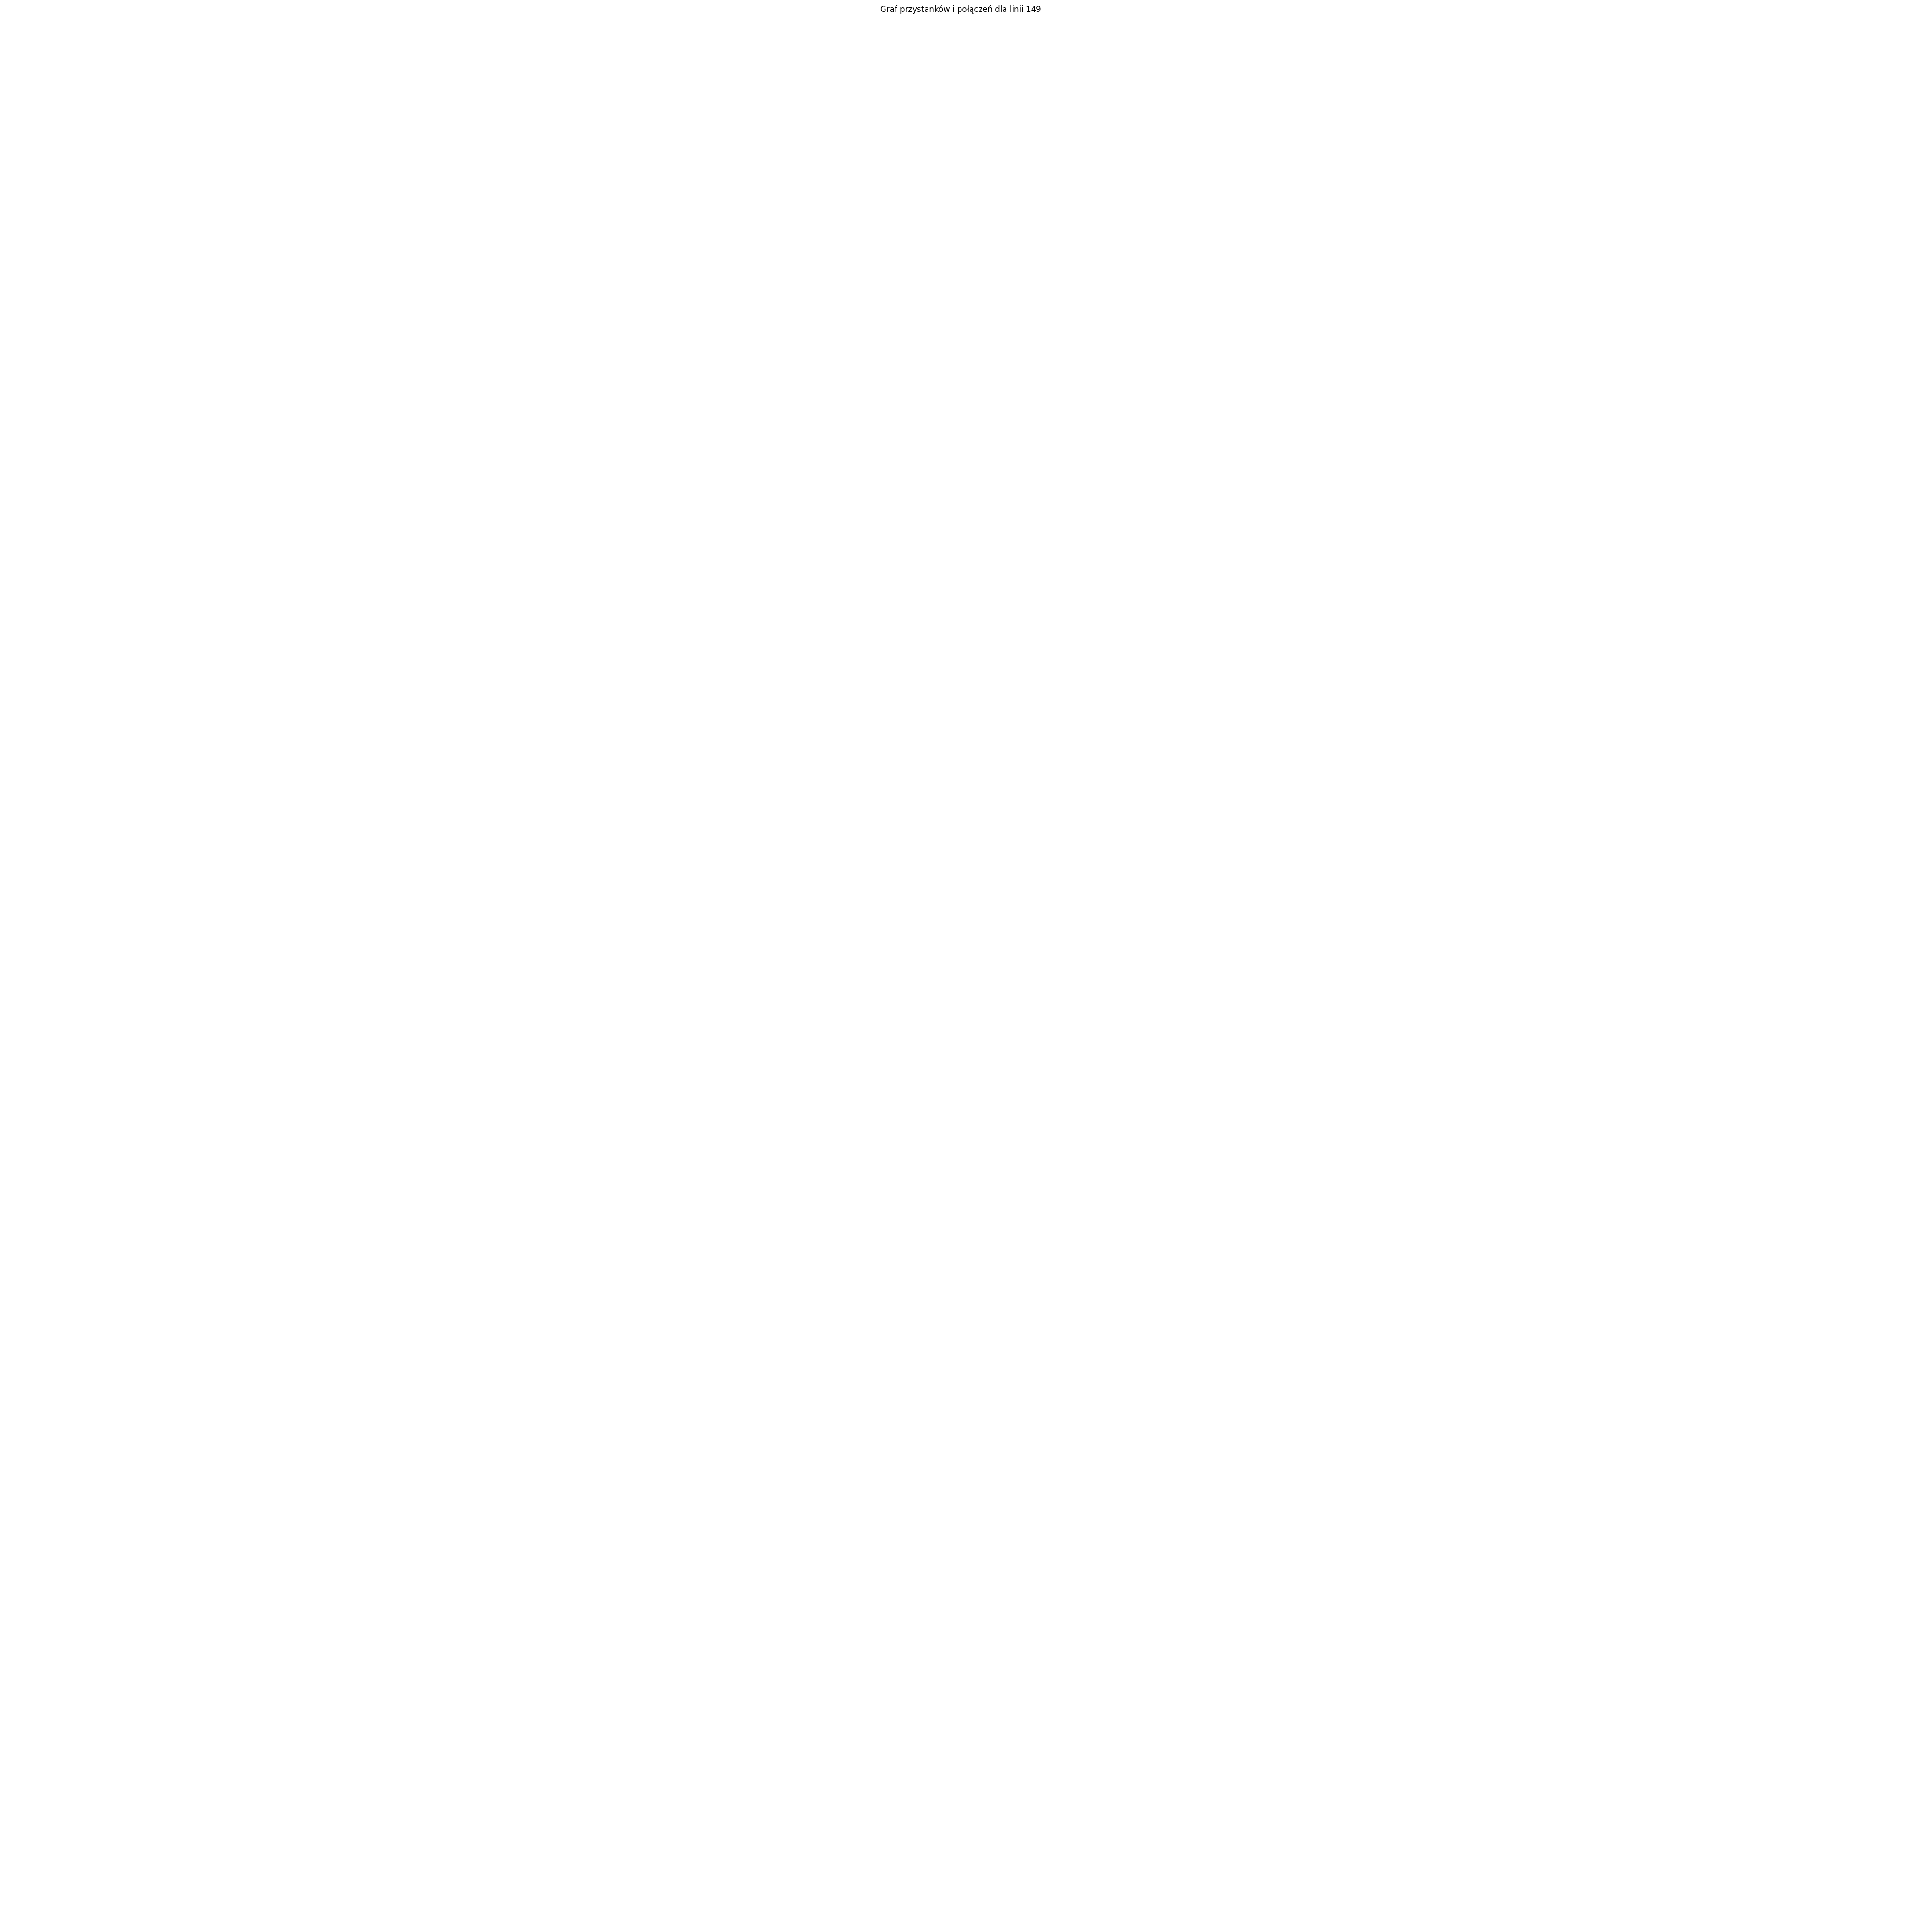

In [67]:
import networkx as nx
import matplotlib.pyplot as plt

# Funkcja do filtrowania połączeń dla danej linii
def filter_connections_for_line(stop_graph, line):
    filtered_graph = {}
    for stop, stop_obj in stop_graph.items():
        # Filtrowanie przystanków, które mają połączenia z wybraną linią
        has_connection = any(connection.line == line for connection in stop_obj.connections)
        if has_connection:
            filtered_graph[stop] = stop_obj
    return filtered_graph

# Funkcja do rysowania grafu
def draw_graph(stop_graph, line=None):
    G = nx.DiGraph()

    # Filtruj dane, jeśli podano linię
    if line:
        stop_graph = filter_connections_for_line(stop_graph, line)

    # Dodaj węzły do grafu
    for stop, stop_obj in stop_graph.items():
        G.add_node(stop, label=stop_obj.name, pos=(stop_obj.lon, stop_obj.lat))

    # Dodaj krawędzie (połączenia) do grafu
    for stop, stop_obj in stop_graph.items():
        for connection in stop_obj.connections:
            if line and connection.line == line:
                G.add_edge(connection.start.name, connection.end.name, label=connection.line)

    # Pobieramy pozycje węzłów
    pos = nx.get_node_attributes(G, 'pos')

    if line:
        plt.figure(figsize=(40, 40))
    else:
        plt.figure(figsize=(150, 150))
        
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color="lightblue", edge_color="gray", font_size=10, font_weight="bold", arrows=True)

    # Etykiety krawędzi (linii)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(f"Graf przystanków i połączeń dla linii {line}" if line else "Graf wszystkich przystanków i połączeń")
    plt.show()

# Wywołanie funkcji:
draw_graph(stop_graph, line="149")
